In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib

import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
from time import time
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import psutil
#from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
#import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

In [3]:
from scipy.interpolate import interp1d as interp1d

In [29]:
#func_path_1 = ('fly_262', '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_261/func_0/')
#func_path_2 = ('fly_262','/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/func_0/')
func_path_1 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_261/func_0/'
func_path_2 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/func_0/'

In [30]:
flies_func_paths = [func_path_1,func_path_2]
#flies_func_paths = [func_path_2]

In [31]:
def get_nav_neural_correlates(func_path):
    ###########################
    ### PREP VISUAL STIMULI ###
    ###########################
    
    # fly_name, func_path = func_path

    vision_path = os.path.join(func_path, 'visual')
    ### Load Photodiode ###
    t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
    stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
    ### Unifrom the units and Make then intigers ###
    stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


    ####################
    ### Prep Fictrac ###
    ####################

    fictrac_path = os.path.join(func_path, 'fictrac')
    fictrac_raw = brainsss.load_fictrac(fictrac_path)

    fps = 100
    resolution = 10 #desired resolution in ms
    expt_len = fictrac_raw.shape[0]/fps*1000
    behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
    fictrac = {}
    for behavior in behaviors:
        if behavior == 'dRotLabY': short = 'Y'
        elif behavior == 'dRotLabZ': short = 'Z'
        elif behavior == 'heading': short = 'h'
        fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
        #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
    fictrac_timestamps = np.arange(0,expt_len,resolution)

    fictrac['h'] = np.rad2deg(fictrac['h'])

    def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
        traces = []
        for i in range(len(stim_times)):
            trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
            if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
                traces.append(trace)
        traces = np.asarray(traces)
        mean_trace = np.mean(traces,axis=0)
        sem_trace = scipy.stats.sem(traces,axis=0)
        return traces, mean_trace, sem_trace


    
    
    heading = fictrac['h']
    heading = heading%360
    
    ##################################################################
    ### Downsample the 100Hz fictrac data to 3384 neual data frame ###
    ##################################################################
    timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
    fictrac_timestamps = np.arange(0,1800000,10)

    def interpolate_to_neural(slice_num, timestamps):
        x = timestamps[:, slice_num]
        f = interp1d(fictrac_timestamps, heading, fill_value="extrapolate") 
        ynew = f(x)
        return ynew

    fwd = fictrac['Y']
    def interpolate_to_neural_fwd(slice_num, timestamps):
        x = timestamps[:, slice_num]
        f = interp1d(fictrac_timestamps, fwd, fill_value="extrapolate") 
        ynew = f(x)
        return ynew

    ang = fictrac['Z']
    def interpolate_to_neural_ang(slice_num, timestamps):
        x = timestamps[:, slice_num]
        f = interp1d(fictrac_timestamps, ang, fill_value="extrapolate") 
        ynew = f(x)
        return ynew

    heading_interpolated = interpolate_to_neural(0,timestamps)
    ### redefine 0
    heading_interpolated -= 180
    fwd_interpolated = interpolate_to_neural_fwd(0,timestamps)
    ang_interpolated = interpolate_to_neural_ang(0,timestamps)
    
    neural_file = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5') #
    with h5py.File(neural_file, 'r') as h:
        print(h['data'].shape)
        neural = h['data'][:]
        
    # Define cluster boundaries
    fixation_range = (-20, 20)
    away_ranges = [(-180, -160), (160, 180)]
    stop_fwd_threshold = 0.5
    stop_ang_threshold = 10
    # Initialize empty arrays for each cluster
    fixation = []
    away = []
    rest = []
    pause = []

    # Loop through each angle and categorize it
    for t, angle in enumerate(heading_interpolated.flatten()):
        if angle >= fixation_range[0] and angle <= fixation_range[1]:
            if np.abs(fwd_interpolated[t])>stop_fwd_threshold or np.abs(ang_interpolated[t])>stop_ang_threshold:
                fixation.append(t)
            else:
                pause.append(t)
        elif angle >= away_ranges[0][0] and angle <= away_ranges[0][1]:
            if np.abs(fwd_interpolated[t])>stop_fwd_threshold or np.abs(ang_interpolated[t])>stop_ang_threshold:
                away.append(t)
            else:
                pause.append(t)
        elif angle >= away_ranges[1][0] and angle <= away_ranges[1][1]:
            if np.abs(fwd_interpolated[t])>stop_fwd_threshold or np.abs(ang_interpolated[t])>stop_ang_threshold:
                away.append(t)
            else:
                pause.append(t)
        else:
            rest.append(t)

    # Print the number of angles in each cluster
    # print(f"Fixation: {len(fixation)}")
    # print(f"Away: {len(away)}")
    # print(f"Rest: {len(rest)}")
    # print(f"Pause: {len(pause)}")
    # fixation, away, stop, and menotaxis are list of t (idex number in 3384)

    pre_menotaxis = []
    menotaxis = []
    others = []
    for t in rest:
        if np.abs(fwd_interpolated[t])<stop_fwd_threshold and np.abs(ang_interpolated[t])<stop_ang_threshold:
            pause.append(t)
        else:
            pre_menotaxis.append(t)
    # print(f"Pause: {len(pause)}")
    # print(f"pre_menotaxis: {len(pre_menotaxis)}")

    pre_menotaxis_angles = [heading_interpolated.flatten()[t] for t in pre_menotaxis]
    pre_menotaxis_angles = np.asarray(pre_menotaxis_angles)

    for t, angle in enumerate(pre_menotaxis_angles.flatten()):
        duration = pre_menotaxis_angles.flatten()[t:t+10] 
        # the fly needs to stabilize the bar within a range of 40 degrees for at least 5s, which is 10 imaging time units
        if np.max(duration) - np.min(duration) <= 40:
            menotaxis.append(t)
        else:
            others.append(t)
    # print(f"menotaxis: {len(menotaxis)}")
    # print(f"others: {len(others)}")

    print(f"Fixation: {len(fixation)}")
    print(f"Away: {len(away)}")
    print(f"Others: {len(others)}")
    print(f"Pause: {len(pause)}")
    print(f"Menotaxis: {len(menotaxis)}")
    print(f"Sum: {len(fixation)+len(away)+len(others)+len(pause)+len(menotaxis)}")
    # brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_26', fixed=fixed, anat_to_mean_type='myr')
#     nav_correlates = {'fix':brainsss.warp_STA_brain((neural[:,:,:,fixation],fly='fly_262'fixed=fixed, anat_to_mean_type='myr') 
#                       'escape':neural[:,:,:,away], 
#                       'meno':neural[:,:,:,menotaxis], 
#                       'pause':neural[:,:,:,pause], 
#                       'other':neural[:,:,:,others]}
    nav_correlates = {'fix':neural[:,:,:,fixation],
                      'escape':neural[:,:,:,away], 
                      'meno':neural[:,:,:,menotaxis], 
                      'pause':neural[:,:,:,pause], 
                      'other':neural[:,:,:,others]}
    
    return nav_correlates

In [32]:
nav_correlates_all_flies = {'fix':[], 'escape':[], 'meno':[], 'pause':[], 'other':[]}

for func_path in flies_func_paths:
    nav_correlates_fly = get_nav_neural_correlates(func_path)
    for k,v in nav_correlates_fly.items():
        nav_correlates_all_flies[k].append(v)
        

loading photodiode data... done
Trying to load timestamp data from hdf5 file.
Success.
(256, 128, 49, 3384)
Fixation: 264
Away: 179
Others: 1403
Pause: 1189
Menotaxis: 349
Sum: 3384
loading photodiode data... done
Trying to load timestamp data from hdf5 file.
Success.
(256, 128, 49, 3384)
Fixation: 342
Away: 186
Others: 2373
Pause: 430
Menotaxis: 53
Sum: 3384


In [33]:
nav_correlates_all_flies['fix'] = np.concatenate(nav_correlates_all_flies['fix'], axis=-1)    
nav_correlates_all_flies['escape'] = np.concatenate(nav_correlates_all_flies['escape'], axis=-1)
nav_correlates_all_flies['meno'] = np.concatenate(nav_correlates_all_flies['meno'], axis=-1)
nav_correlates_all_flies['pause'] = np.concatenate(nav_correlates_all_flies['pause'], axis=-1)
nav_correlates_all_flies['other'] = np.concatenate(nav_correlates_all_flies['other'], axis=-1)


In [28]:
warps = brainsss.warp_STA_brain(STA_brain=nav_correlates_all_flies['fix'], fly= func_path_2, fixed, anat_to_mean_type='myr')

SyntaxError: positional argument follows keyword argument (<ipython-input-28-e2fbb2373b1e>, line 1)

In [7]:
[x.shape for x in nav_correlates_all_flies['fix']]


[(256, 128, 49, 264), (256, 128, 49, 342)]

In [ ]:
# fixation_average = nav_correlates_all_flies['fix'].mean(axis = -1, keepdims=True)

In [47]:
fixation_average = nav_correlates_all_flies['fix'].mean(axis = -1)
away_average = nav_correlates_all_flies['escape'].mean(axis = -1)
meno_average = nav_correlates_all_flies['meno'].mean(axis = -1)
others_average = nav_correlates_all_flies['other'].mean(axis = -1)
pause_average = nav_correlates_all_flies['pause'].mean(axis = -1)

In [38]:
np.shape(fixation_average)

(256, 128, 49)

In [37]:
fixation_average = nav_correlates_all_flies['fix'].mean(axis = -1)

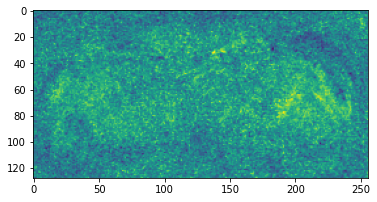

In [88]:
z = 23
plt.imshow(fixation_average[:,:,z].T)


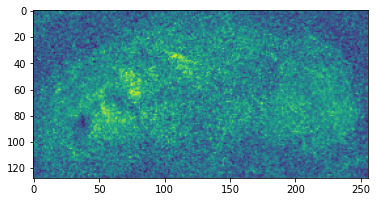

In [89]:
plt.imshow(away_average[:,:,z].T)

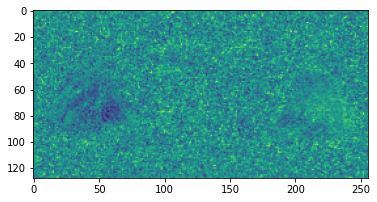

In [64]:
z = 28
plt.imshow(meno_average[:,:,z].T)


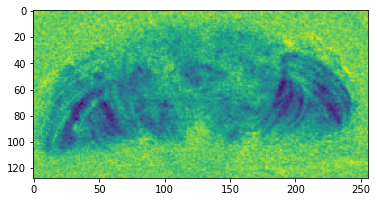

In [67]:
z = 20
plt.imshow(pause_average[:,:,z].T)


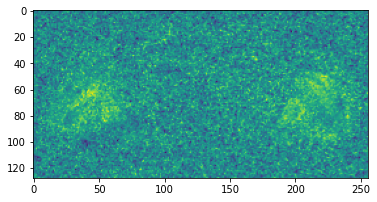

In [70]:
z = 28
plt.imshow(others_average[:,:,z].T)


In [ ]:
z = 26
plt.imshow(away_average[:,:,z].T)


In [15]:
input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
vmax = 0.5
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    fixation_average[:,:,:,0],
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='seismic',
                                                   diverging=True)#'hot')

ValueError: operands could not be broadcast together with shapes (314,146,91) (256,128,49) 

In [ ]:
warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly= func_path_2, fixed=fixed, anat_to_mean_type='myr')

In [8]:
atlas = brainsss.load_roi_atlas()

explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [ ]:
####### Explode the brain #############
all_explosions = {}
for condition in ['ve_no_0','ve_no_180','ve_0','ve_180']:
    print(condition)
    
    if '180' in condition:
        angle = 180
    else:
        angle = 0
    if 'no' in condition:
        event_times_list = ve_no_turn_times[angle]
    else:
        event_times_list = ve_turn_times[angle]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_134', fixed=fixed, anat_to_mean_type='myr')
    print(F'Warps {time.time()-t0}')
    
    explosions = []
    t0 = time.time()
    for tp in range(24):
        input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
        data_to_plot = warps[tp][:,:,::-1]
        vmax = 0.5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                           diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[condition] = explosions